# Upsampling
Example from
http://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/

[[ 0.          0.16666667  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.33333333  0.5         0.66666667]]


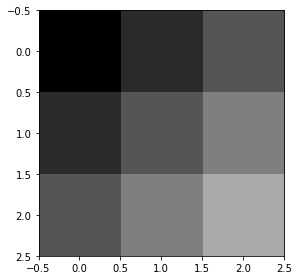

In [6]:
%matplotlib inline

import numpy as np #ogrid, repeat, newaxis
from skimage import io

"""
Generate image that will be used for test upsampling.
Number of channels is 3 --  we also treat the number of 
samples like the number of classes, because later on 
that will be used to upsample preductions from the network
"""

imsize = 3
x,y = np.ogrid[:imsize, :imsize]
img = np.repeat((x+y)[...,np.newaxis],3,2)/float(imsize + imsize)
io.imshow(img,interpolation='none')
print(img[:,:,0])

In [2]:
import skimage.transform

def upsample_skimage(factor, input_img):
    # Pad with 0 values, similar to how TF does it
    # Order=1 is bilinear upsampling
    
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)

[[ 0.          0.03125     0.09375     0.15625     0.21875     0.1875    ]
 [ 0.03125     0.08333333  0.16666667  0.25        0.33333333  0.28125   ]
 [ 0.09375     0.16666667  0.25        0.33333333  0.41666667  0.34375   ]
 [ 0.15625     0.25        0.33333333  0.41666667  0.5         0.40625   ]
 [ 0.21875     0.33333333  0.41666667  0.5         0.58333333  0.46875   ]
 [ 0.1875      0.28125     0.34375     0.40625     0.46875     0.375     ]]


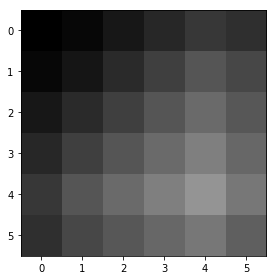

In [8]:
upsampled_img_skimage = upsample_skimage(factor=2,input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')
print(upsampled_img_skimage[:,:,0])

In [9]:
#impprt numpy as np
import tensorflow as tf

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling
    """
    return(2*factor-factor%2)

def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h,w) size
    """
    factor = (size + 1) // 2
    
    if size%2==1:
        center = factor-1
    else:
        center = factor-0.5
    
    og = np.ogrid[:size, :size]
    
    return((1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor) )

def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                       filter_size,
                       number_of_classes,
                       number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    print(upsample_kernel)
    for i in range(number_of_classes):
        weights[:,:,i,i] = upsample_kernel
    
    return(weights)

def upsample_tf(factor, input_img):
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)
    
    with tf.Graph().as_default():
        with tf.Session() as sess:
            upsample_filt_pl = tf.placeholder(tf.float32)
            logits_pl = tf.placeholder(tf.float32)
            upsample_filter_np = bilinear_upsample_weights(factor, 
                                                           number_of_classes)
            res = tf.nn.conv2d_transpose(logits_pl, 
                                          upsample_filt_pl,
                                          output_shape=[1,
                                                       new_height,
                                                       new_width,
                                                       number_of_classes],
                                          strides=[1,factor,factor,1])
            final_result = sess.run(res,
                               feed_dict={upsample_filt_pl: upsample_filter_np,
                                          logits_pl: expanded_img})
    return(final_result.squeeze())

[[ 0.0625  0.1875  0.1875  0.0625]
 [ 0.1875  0.5625  0.5625  0.1875]
 [ 0.1875  0.5625  0.5625  0.1875]
 [ 0.0625  0.1875  0.1875  0.0625]]
[[ 0.          0.03125     0.09375     0.15625     0.21875     0.1875    ]
 [ 0.03125     0.08333334  0.16666666  0.25        0.33333331  0.28125   ]
 [ 0.09375     0.16666666  0.25        0.33333334  0.41666666  0.34375   ]
 [ 0.15625     0.25        0.33333331  0.41666666  0.5         0.40625   ]
 [ 0.21875     0.33333334  0.41666666  0.5         0.58333337  0.46875   ]
 [ 0.1875      0.28125     0.34375     0.40625     0.46875     0.375     ]]


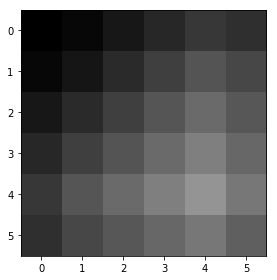

In [15]:
upsampled_img_tf = upsample_tf(factor=2, input_img=img)
io.imshow(upsampled_img_tf)
print(upsampled_img_tf[:,:,0])

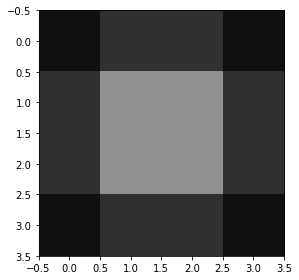

In [13]:
# Just visualizing the kernel
tmp = np.array([[0.0625, 0.1875, 0.1875, 0.0625],
                [0.1875, 0.5625, 0.5625, 0.1875],
                [0.1875, 0.5625, 0.5625, 0.1875],
                [0.0625, 0.1875, 0.1875, 0.0625]])
io.imshow(tmp)

In [20]:
# Test if the results of upsampling are the same
np.allclose(upsampled_img_skimage, upsampled_img_tf)

True

Check for factor 2: True
Check for factor 3: True
Check for factor 4: True
Check for factor 5: True
Check for factor 6: True
Check for factor 7: True
Check for factor 8: True
Check for factor 9: True


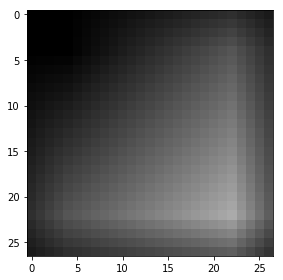

In [22]:
for factor in range(2, 10):
    upsampled_img_skimage = upsample_skimage(factor=factor, input_img=img)
    upsampled_img_tf = upsample_tf(factor=factor, input_img=img)
    
    are_equal = np.allclose(upsampled_img_skimage, upsampled_img_tf)
    
    print("Check for factor {}: {}".format(factor, are_equal))

io.imshow(upsampled_img_tf)